# HW3 Image Classification
## We strongly recommend that you run with [Kaggle](https://www.kaggle.com/t/86ca241732c04da99aca6490080bae73) for this homework

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2023-spring@googlegroups.com

# Check GPU Type

In [1]:
!nvidia-smi

Fri Mar 31 13:09:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.49       Driver Version: 528.49       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P8    N/A /  N/A |      0MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get Data
Notes: if the links are dead, you can download the data directly from Kaggle and upload it to the workspace, or you can use the Kaggle API to directly download the data into colab.


In [2]:
# Download Link
# Link 1 (Dropbox): https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0
# Link 2 (Google Drive): https://drive.google.com/file/d/1tbGNwk1yGoCBdu4Gi_Cia7EJ9OhubYD9/view?usp=share_link
# Link 3: Kaggle Competition.

# (1) dropbox link
!wget -O food11.zip https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0

# (2) google drive link
# !gdown --id '1tbGNwk1yGoCBdu4Gi_Cia7EJ9OhubYD9' --output food11.zip

'wget' 不是內部或外部命令、可執行的程式或批次檔。


In [3]:
! unzip food11.zip

'unzip' 不是內部或外部命令、可執行的程式或批次檔。


# Import Packages

In [6]:
_exp_name = "sample"

In [7]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# This is for the progress bar.
from tqdm.auto import tqdm
import random

In [8]:
myseed = 24  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Transforms
Torchvision provides lots of useful utilities for image preprocessing, data *wrapping* as well as data augmentation.

Please refer to PyTorch official website for details about different transforms.

In [9]:
# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
#參考資料:https://zhuanlan.zhihu.com/p/476297637 、https://zhuanlan.zhihu.com/p/144997215
test_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(225),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((256, 256)),
    transforms.CenterCrop(225),
    transforms.RandomRotation(35),
#     transforms.RandomAffine(degrees=0, translate=(0.24, 0.24), shear=0.24),
    transforms.RandomAffine(degrees=0, translate=(0.25, 0.25), shear=0.24),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),
#     transforms.RandomRotation(degrees=(0, 180)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Datasets
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [5]:
class FoodDataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
            
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        
        try:
            label = int(fname.split("\\")[-1].split("_")[0])
        except:
            label = -1 # test has no label
            
        return im,label

# Model

In [6]:
#0.81591
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 128, 128]
        
        self.cnn = nn.Sequential(
            
            nn.Conv2d(3, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # 64 * 111 * 111 -> 128 * 54 * 54
            nn.Conv2d(128, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # 128 * 54 * 54 -> 256 * 26 * 26
            nn.Conv2d(256, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # 256 * 26 * 26  -> 256 * 12 * 12
            nn.Conv2d(256, 512, 3),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # 256 * 12 * 12  -> 512 * 5 * 5
            nn.Conv2d(512, 1024, 3),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
#             nn.Conv2d(1024, 2048, 3),
#             nn.BatchNorm2d(2048),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2),
            
#             nn.Conv2d(512, 1024, 1),
#             nn.BatchNorm2d(1024),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=1),
            
            
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.BatchNorm1d(25600 ),
            nn.Linear(25600  , 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.Linear(1024, 11),

        )
        




    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

# Configurations

In [7]:
# "cuda" only when GPUs are available.
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f'DEVICE: {device}')
# Initialize a model, and put it on the device specified.

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'DEVICE: {device}')

model = Classifier().to(device)

# The number of batch size.
batch_size = 128

# The number of training epochs.
n_epochs = 100

# If no improvement in 'patience' epochs, early stop.
patience = 10

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) 

DEVICE: cuda


# Dataloader

In [8]:
# Construct train and valid datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset("./train", tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset("./valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Start Training

In [9]:
# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=2, T_mult=5, eta_min=0.0000,verbose = True)

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    
    scheduler.step()
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

Epoch 00000: adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00001: adjusting learning rate of group 0 to 5.0000e-04.
[ Train | 001/100 ] loss = 2.19761, acc = 0.27581


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 001/100 ] loss = 1.93715, acc = 0.33923
[ Valid | 001/100 ] loss = 1.93715, acc = 0.33923 -> best
Best model found at epoch 0, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00002: adjusting learning rate of group 0 to 1.0000e-03.
[ Train | 002/100 ] loss = 1.84045, acc = 0.37540


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 002/100 ] loss = 1.70257, acc = 0.41058
[ Valid | 002/100 ] loss = 1.70257, acc = 0.41058 -> best
Best model found at epoch 1, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00003: adjusting learning rate of group 0 to 9.7553e-04.
[ Train | 003/100 ] loss = 1.75088, acc = 0.40239


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 003/100 ] loss = 1.66770, acc = 0.41735
[ Valid | 003/100 ] loss = 1.66770, acc = 0.41735 -> best
Best model found at epoch 2, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00004: adjusting learning rate of group 0 to 9.0451e-04.
[ Train | 004/100 ] loss = 1.61421, acc = 0.45144


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 004/100 ] loss = 1.65324, acc = 0.43312
[ Valid | 004/100 ] loss = 1.65324, acc = 0.43312 -> best
Best model found at epoch 3, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00005: adjusting learning rate of group 0 to 7.9389e-04.
[ Train | 005/100 ] loss = 1.53813, acc = 0.47241


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 005/100 ] loss = 1.93467, acc = 0.38714
[ Valid | 005/100 ] loss = 1.93467, acc = 0.38714


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00006: adjusting learning rate of group 0 to 6.5451e-04.
[ Train | 006/100 ] loss = 1.43669, acc = 0.50969


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 006/100 ] loss = 1.41631, acc = 0.50618
[ Valid | 006/100 ] loss = 1.41631, acc = 0.50618 -> best
Best model found at epoch 5, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00007: adjusting learning rate of group 0 to 5.0000e-04.
[ Train | 007/100 ] loss = 1.35227, acc = 0.53125


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 007/100 ] loss = 1.35524, acc = 0.52678
[ Valid | 007/100 ] loss = 1.35524, acc = 0.52678 -> best
Best model found at epoch 6, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00008: adjusting learning rate of group 0 to 3.4549e-04.
[ Train | 008/100 ] loss = 1.26839, acc = 0.56290


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 008/100 ] loss = 1.21826, acc = 0.56248
[ Valid | 008/100 ] loss = 1.21826, acc = 0.56248 -> best
Best model found at epoch 7, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00009: adjusting learning rate of group 0 to 2.0611e-04.
[ Train | 009/100 ] loss = 1.20529, acc = 0.57902


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 009/100 ] loss = 1.24055, acc = 0.57882
[ Valid | 009/100 ] loss = 1.24055, acc = 0.57882 -> best
Best model found at epoch 8, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00010: adjusting learning rate of group 0 to 9.5492e-05.
[ Train | 010/100 ] loss = 1.12318, acc = 0.60779


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 010/100 ] loss = 1.10195, acc = 0.62296
[ Valid | 010/100 ] loss = 1.10195, acc = 0.62296 -> best
Best model found at epoch 9, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00011: adjusting learning rate of group 0 to 2.4472e-05.
[ Train | 011/100 ] loss = 1.06153, acc = 0.63261


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 011/100 ] loss = 1.03713, acc = 0.64268
[ Valid | 011/100 ] loss = 1.03713, acc = 0.64268 -> best
Best model found at epoch 10, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00012: adjusting learning rate of group 0 to 1.0000e-03.
[ Train | 012/100 ] loss = 1.00265, acc = 0.65111


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 012/100 ] loss = 1.00231, acc = 0.65161
[ Valid | 012/100 ] loss = 1.00231, acc = 0.65161 -> best
Best model found at epoch 11, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00013: adjusting learning rate of group 0 to 9.9901e-04.
[ Train | 013/100 ] loss = 1.29102, acc = 0.55548


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 013/100 ] loss = 1.46816, acc = 0.50725
[ Valid | 013/100 ] loss = 1.46816, acc = 0.50725


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00014: adjusting learning rate of group 0 to 9.9606e-04.
[ Train | 014/100 ] loss = 1.27367, acc = 0.55548


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 014/100 ] loss = 1.39006, acc = 0.54367
[ Valid | 014/100 ] loss = 1.39006, acc = 0.54367


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00015: adjusting learning rate of group 0 to 9.9114e-04.
[ Train | 015/100 ] loss = 1.23584, acc = 0.57625


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 015/100 ] loss = 1.84984, acc = 0.40326
[ Valid | 015/100 ] loss = 1.84984, acc = 0.40326


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00016: adjusting learning rate of group 0 to 9.8429e-04.
[ Train | 016/100 ] loss = 1.16791, acc = 0.59237


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 016/100 ] loss = 1.48235, acc = 0.54272
[ Valid | 016/100 ] loss = 1.48235, acc = 0.54272


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00017: adjusting learning rate of group 0 to 9.7553e-04.
[ Train | 017/100 ] loss = 1.14790, acc = 0.60710


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 017/100 ] loss = 1.39740, acc = 0.54340
[ Valid | 017/100 ] loss = 1.39740, acc = 0.54340


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00018: adjusting learning rate of group 0 to 9.6489e-04.
[ Train | 018/100 ] loss = 1.11104, acc = 0.61739


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 018/100 ] loss = 1.13552, acc = 0.61358
[ Valid | 018/100 ] loss = 1.13552, acc = 0.61358


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00019: adjusting learning rate of group 0 to 9.5241e-04.
[ Train | 019/100 ] loss = 1.06600, acc = 0.63558


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 019/100 ] loss = 1.19611, acc = 0.59481
[ Valid | 019/100 ] loss = 1.19611, acc = 0.59481


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00020: adjusting learning rate of group 0 to 9.3815e-04.
[ Train | 020/100 ] loss = 1.03202, acc = 0.64755


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 020/100 ] loss = 1.68397, acc = 0.52827
[ Valid | 020/100 ] loss = 1.68397, acc = 0.52827


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00021: adjusting learning rate of group 0 to 9.2216e-04.
[ Train | 021/100 ] loss = 1.00480, acc = 0.65437


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 021/100 ] loss = 1.07856, acc = 0.63526
[ Valid | 021/100 ] loss = 1.07856, acc = 0.63526


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00022: adjusting learning rate of group 0 to 9.0451e-04.
[ Train | 022/100 ] loss = 0.97659, acc = 0.66644


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 022/100 ] loss = 1.04132, acc = 0.65956
[ Valid | 022/100 ] loss = 1.04132, acc = 0.65956 -> best
Best model found at epoch 21, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00023: adjusting learning rate of group 0 to 8.8526e-04.
[ Train | 023/100 ] loss = 0.95300, acc = 0.67642


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 023/100 ] loss = 1.08220, acc = 0.64002
[ Valid | 023/100 ] loss = 1.08220, acc = 0.64002


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00024: adjusting learning rate of group 0 to 8.6448e-04.
[ Train | 024/100 ] loss = 0.90717, acc = 0.68869


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 024/100 ] loss = 1.14005, acc = 0.65323
[ Valid | 024/100 ] loss = 1.14005, acc = 0.65323


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00025: adjusting learning rate of group 0 to 8.4227e-04.
[ Train | 025/100 ] loss = 0.88737, acc = 0.69739


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 025/100 ] loss = 1.08729, acc = 0.64730
[ Valid | 025/100 ] loss = 1.08729, acc = 0.64730


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00026: adjusting learning rate of group 0 to 8.1871e-04.
[ Train | 026/100 ] loss = 0.87092, acc = 0.70095


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 026/100 ] loss = 0.95352, acc = 0.68974
[ Valid | 026/100 ] loss = 0.95352, acc = 0.68974 -> best
Best model found at epoch 25, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00027: adjusting learning rate of group 0 to 7.9389e-04.
[ Train | 027/100 ] loss = 0.84278, acc = 0.71282


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 027/100 ] loss = 1.35301, acc = 0.59386
[ Valid | 027/100 ] loss = 1.35301, acc = 0.59386


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00028: adjusting learning rate of group 0 to 7.6791e-04.
[ Train | 028/100 ] loss = 0.80029, acc = 0.72627


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 028/100 ] loss = 1.03779, acc = 0.68412
[ Valid | 028/100 ] loss = 1.03779, acc = 0.68412


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00029: adjusting learning rate of group 0 to 7.4088e-04.
[ Train | 029/100 ] loss = 0.78271, acc = 0.73329


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 029/100 ] loss = 1.13133, acc = 0.65467
[ Valid | 029/100 ] loss = 1.13133, acc = 0.65467


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00030: adjusting learning rate of group 0 to 7.1289e-04.
[ Train | 030/100 ] loss = 0.75008, acc = 0.74407


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 030/100 ] loss = 0.93045, acc = 0.70176
[ Valid | 030/100 ] loss = 0.93045, acc = 0.70176 -> best
Best model found at epoch 29, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00031: adjusting learning rate of group 0 to 6.8406e-04.
[ Train | 031/100 ] loss = 0.73717, acc = 0.74693


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 031/100 ] loss = 1.07468, acc = 0.65879
[ Valid | 031/100 ] loss = 1.07468, acc = 0.65879


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00032: adjusting learning rate of group 0 to 6.5451e-04.
[ Train | 032/100 ] loss = 0.71034, acc = 0.75831


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 032/100 ] loss = 0.99843, acc = 0.69493
[ Valid | 032/100 ] loss = 0.99843, acc = 0.69493


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00033: adjusting learning rate of group 0 to 6.2434e-04.
[ Train | 033/100 ] loss = 0.66844, acc = 0.77146


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 033/100 ] loss = 1.17594, acc = 0.66185
[ Valid | 033/100 ] loss = 1.17594, acc = 0.66185


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00034: adjusting learning rate of group 0 to 5.9369e-04.
[ Train | 034/100 ] loss = 0.65624, acc = 0.77433


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 034/100 ] loss = 0.94014, acc = 0.70167
[ Valid | 034/100 ] loss = 0.94014, acc = 0.70167


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00035: adjusting learning rate of group 0 to 5.6267e-04.
[ Train | 035/100 ] loss = 0.64774, acc = 0.77690


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 035/100 ] loss = 0.79460, acc = 0.75614
[ Valid | 035/100 ] loss = 0.79460, acc = 0.75614 -> best
Best model found at epoch 34, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00036: adjusting learning rate of group 0 to 5.3140e-04.
[ Train | 036/100 ] loss = 0.61957, acc = 0.78877


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 036/100 ] loss = 0.78551, acc = 0.74568
[ Valid | 036/100 ] loss = 0.78551, acc = 0.74568


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00037: adjusting learning rate of group 0 to 5.0000e-04.
[ Train | 037/100 ] loss = 0.60915, acc = 0.79094


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 037/100 ] loss = 0.76446, acc = 0.75062
[ Valid | 037/100 ] loss = 0.76446, acc = 0.75062


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00038: adjusting learning rate of group 0 to 4.6860e-04.
[ Train | 038/100 ] loss = 0.56815, acc = 0.80627


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 038/100 ] loss = 0.92233, acc = 0.72027
[ Valid | 038/100 ] loss = 0.92233, acc = 0.72027


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00039: adjusting learning rate of group 0 to 4.3733e-04.
[ Train | 039/100 ] loss = 0.54277, acc = 0.81092


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 039/100 ] loss = 0.81827, acc = 0.74793
[ Valid | 039/100 ] loss = 0.81827, acc = 0.74793


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00040: adjusting learning rate of group 0 to 4.0631e-04.
[ Train | 040/100 ] loss = 0.54322, acc = 0.81586


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 040/100 ] loss = 0.75329, acc = 0.75915
[ Valid | 040/100 ] loss = 0.75329, acc = 0.75915 -> best
Best model found at epoch 39, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00041: adjusting learning rate of group 0 to 3.7566e-04.
[ Train | 041/100 ] loss = 0.50623, acc = 0.82367


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 041/100 ] loss = 0.84622, acc = 0.75058
[ Valid | 041/100 ] loss = 0.84622, acc = 0.75058


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00042: adjusting learning rate of group 0 to 3.4549e-04.
[ Train | 042/100 ] loss = 0.48244, acc = 0.83722


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 042/100 ] loss = 0.81074, acc = 0.76179
[ Valid | 042/100 ] loss = 0.81074, acc = 0.76179 -> best
Best model found at epoch 41, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00043: adjusting learning rate of group 0 to 3.1594e-04.
[ Train | 043/100 ] loss = 0.44662, acc = 0.84949


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 043/100 ] loss = 0.78439, acc = 0.76683
[ Valid | 043/100 ] loss = 0.78439, acc = 0.76683 -> best
Best model found at epoch 42, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00044: adjusting learning rate of group 0 to 2.8711e-04.
[ Train | 044/100 ] loss = 0.42137, acc = 0.85740


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 044/100 ] loss = 0.66538, acc = 0.79224
[ Valid | 044/100 ] loss = 0.66538, acc = 0.79224 -> best
Best model found at epoch 43, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00045: adjusting learning rate of group 0 to 2.5912e-04.
[ Train | 045/100 ] loss = 0.40646, acc = 0.85918


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 045/100 ] loss = 0.65141, acc = 0.79973
[ Valid | 045/100 ] loss = 0.65141, acc = 0.79973 -> best
Best model found at epoch 44, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00046: adjusting learning rate of group 0 to 2.3209e-04.
[ Train | 046/100 ] loss = 0.39451, acc = 0.86877


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 046/100 ] loss = 0.73277, acc = 0.79219
[ Valid | 046/100 ] loss = 0.73277, acc = 0.79219


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00047: adjusting learning rate of group 0 to 2.0611e-04.
[ Train | 047/100 ] loss = 0.37940, acc = 0.86887


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 047/100 ] loss = 0.69584, acc = 0.79835
[ Valid | 047/100 ] loss = 0.69584, acc = 0.79835


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00048: adjusting learning rate of group 0 to 1.8129e-04.
[ Train | 048/100 ] loss = 0.36493, acc = 0.87559


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 048/100 ] loss = 0.69267, acc = 0.79314
[ Valid | 048/100 ] loss = 0.69267, acc = 0.79314


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00049: adjusting learning rate of group 0 to 1.5773e-04.
[ Train | 049/100 ] loss = 0.34395, acc = 0.88380


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 049/100 ] loss = 0.67323, acc = 0.80414
[ Valid | 049/100 ] loss = 0.67323, acc = 0.80414 -> best
Best model found at epoch 48, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00050: adjusting learning rate of group 0 to 1.3552e-04.
[ Train | 050/100 ] loss = 0.32949, acc = 0.88350


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 050/100 ] loss = 0.68720, acc = 0.79880
[ Valid | 050/100 ] loss = 0.68720, acc = 0.79880


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00051: adjusting learning rate of group 0 to 1.1474e-04.
[ Train | 051/100 ] loss = 0.30605, acc = 0.89893


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 051/100 ] loss = 0.62892, acc = 0.81932
[ Valid | 051/100 ] loss = 0.62892, acc = 0.81932 -> best
Best model found at epoch 50, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00052: adjusting learning rate of group 0 to 9.5492e-05.
[ Train | 052/100 ] loss = 0.29077, acc = 0.89972


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 052/100 ] loss = 0.66362, acc = 0.80706
[ Valid | 052/100 ] loss = 0.66362, acc = 0.80706


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00053: adjusting learning rate of group 0 to 7.7836e-05.
[ Train | 053/100 ] loss = 0.27212, acc = 0.90645


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 053/100 ] loss = 0.64261, acc = 0.81829
[ Valid | 053/100 ] loss = 0.64261, acc = 0.81829


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00054: adjusting learning rate of group 0 to 6.1847e-05.
[ Train | 054/100 ] loss = 0.27121, acc = 0.90773


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 054/100 ] loss = 0.62393, acc = 0.81375
[ Valid | 054/100 ] loss = 0.62393, acc = 0.81375


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00055: adjusting learning rate of group 0 to 4.7586e-05.
[ Train | 055/100 ] loss = 0.25707, acc = 0.91782


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 055/100 ] loss = 0.61854, acc = 0.81972
[ Valid | 055/100 ] loss = 0.61854, acc = 0.81972 -> best
Best model found at epoch 54, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00056: adjusting learning rate of group 0 to 3.5112e-05.
[ Train | 056/100 ] loss = 0.25338, acc = 0.91485


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 056/100 ] loss = 0.60795, acc = 0.82376
[ Valid | 056/100 ] loss = 0.60795, acc = 0.82376 -> best
Best model found at epoch 55, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00057: adjusting learning rate of group 0 to 2.4472e-05.
[ Train | 057/100 ] loss = 0.24276, acc = 0.91762


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 057/100 ] loss = 0.60318, acc = 0.82260
[ Valid | 057/100 ] loss = 0.60318, acc = 0.82260


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00058: adjusting learning rate of group 0 to 1.5708e-05.
[ Train | 058/100 ] loss = 0.23439, acc = 0.92346


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 058/100 ] loss = 0.60670, acc = 0.82044
[ Valid | 058/100 ] loss = 0.60670, acc = 0.82044


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00059: adjusting learning rate of group 0 to 8.8564e-06.
[ Train | 059/100 ] loss = 0.22858, acc = 0.92316


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 059/100 ] loss = 0.59949, acc = 0.82430
[ Valid | 059/100 ] loss = 0.59949, acc = 0.82430 -> best
Best model found at epoch 58, saving model


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00060: adjusting learning rate of group 0 to 3.9426e-06.
[ Train | 060/100 ] loss = 0.23389, acc = 0.92217


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 060/100 ] loss = 0.60339, acc = 0.82187
[ Valid | 060/100 ] loss = 0.60339, acc = 0.82187


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00061: adjusting learning rate of group 0 to 9.8664e-07.
[ Train | 061/100 ] loss = 0.22459, acc = 0.92722


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 061/100 ] loss = 0.60439, acc = 0.82336
[ Valid | 061/100 ] loss = 0.60439, acc = 0.82336


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00062: adjusting learning rate of group 0 to 1.0000e-03.
[ Train | 062/100 ] loss = 0.22081, acc = 0.92593


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 062/100 ] loss = 0.60140, acc = 0.82223
[ Valid | 062/100 ] loss = 0.60140, acc = 0.82223


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00063: adjusting learning rate of group 0 to 9.9996e-04.
[ Train | 063/100 ] loss = 0.72858, acc = 0.76088


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 063/100 ] loss = 1.30752, acc = 0.64276
[ Valid | 063/100 ] loss = 1.30752, acc = 0.64276


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00064: adjusting learning rate of group 0 to 9.9984e-04.
[ Train | 064/100 ] loss = 0.72147, acc = 0.75376


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 064/100 ] loss = 0.91865, acc = 0.71079
[ Valid | 064/100 ] loss = 0.91865, acc = 0.71079


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00065: adjusting learning rate of group 0 to 9.9964e-04.
[ Train | 065/100 ] loss = 0.68247, acc = 0.76612


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 065/100 ] loss = 1.90334, acc = 0.58008
[ Valid | 065/100 ] loss = 1.90334, acc = 0.58008


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00066: adjusting learning rate of group 0 to 9.9937e-04.
[ Train | 066/100 ] loss = 0.67693, acc = 0.76859


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 066/100 ] loss = 1.10214, acc = 0.68524
[ Valid | 066/100 ] loss = 1.10214, acc = 0.68524


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00067: adjusting learning rate of group 0 to 9.9901e-04.
[ Train | 067/100 ] loss = 0.65729, acc = 0.77660


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 067/100 ] loss = 0.91733, acc = 0.72686
[ Valid | 067/100 ] loss = 0.91733, acc = 0.72686


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00068: adjusting learning rate of group 0 to 9.9858e-04.
[ Train | 068/100 ] loss = 0.62002, acc = 0.78778


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 068/100 ] loss = 0.96425, acc = 0.71066
[ Valid | 068/100 ] loss = 0.96425, acc = 0.71066


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00069: adjusting learning rate of group 0 to 9.9807e-04.
[ Train | 069/100 ] loss = 0.62067, acc = 0.79569


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 069/100 ] loss = 1.07239, acc = 0.69171
[ Valid | 069/100 ] loss = 1.07239, acc = 0.69171


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 00070: adjusting learning rate of group 0 to 9.9748e-04.
[ Train | 070/100 ] loss = 0.60549, acc = 0.79302


  0%|          | 0/29 [00:00<?, ?it/s]

[ Valid | 070/100 ] loss = 1.95114, acc = 0.58148
[ Valid | 070/100 ] loss = 1.95114, acc = 0.58148
No improvment 10 consecutive epochs, early stopping


##### Dataloader for test

In [10]:
# Construct test datasets.
# The argument "loader" tells how torchvision reads the data.
test_set = FoodDataset("./test", tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# Testing and generate prediction CSV

In [11]:
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()
prediction = []
with torch.no_grad():
    for data,_ in tqdm(test_loader):
        test_pred = model_best(data.to(device))
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()

  0%|          | 0/24 [00:00<?, ?it/s]

In [12]:
# create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(len(test_set))]
df["Category"] = prediction
df.to_csv("submission_test2.csv",index = False)

# Q1. Augmentation Implementation
## Implement augmentation by finishing train_tfm in the code with image size of your choice. 
## Directly copy the following block and paste it on GradeScope after you finish the code
### Your train_tfm must be capable of producing 5+ different results when given an identical image multiple times.
### Your  train_tfm in the report can be different from train_tfm in your training code.


In [14]:
train_tfm = transforms.Compose([

    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),   #將圖像大小調整為 128x128像素
    # You may add some transforms here.

    transforms.RandomGrayscale(p = 0.1),        # 随機圖片灰度化(p為機率)
    transforms.RandomHorizontalFlip( p=0.5 ),      # 随機圖片水平翻轉 (p為機率)
    transforms.RandomVerticalFlip( p=0.5 ) ,       # 随機圖片垂直翻轉(p為機率)
    transforms.RandomSolarize( threshold =0.1, p=0.5 )  ,   #隨機圖片曝光(p為機率)
    transforms.RandomAffine(degrees=8, translate=(0.5, 0.5), shear=0.8),    #隨機仿射變換

    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) #使用 ImageNet 數據集的均值和標準差對圖像進行歸一化
    ])

# Q2. Visual Representations Implementation
## Visualize the learned visual representations of the CNN model on the validation set by implementing t-SNE (t-distributed Stochastic Neighbor Embedding) on the output of both top & mid layers (You need to submit 2 images). 


In [13]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained model
model = Classifier().to(device)
state_dict = torch.load(f"{_exp_name}_best.ckpt")
model.load_state_dict(state_dict)
model.eval()

print(model)

Classifier(
  (cnn): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2,

100%|██████████| 57/57 [00:17<00:00,  3.29it/s]


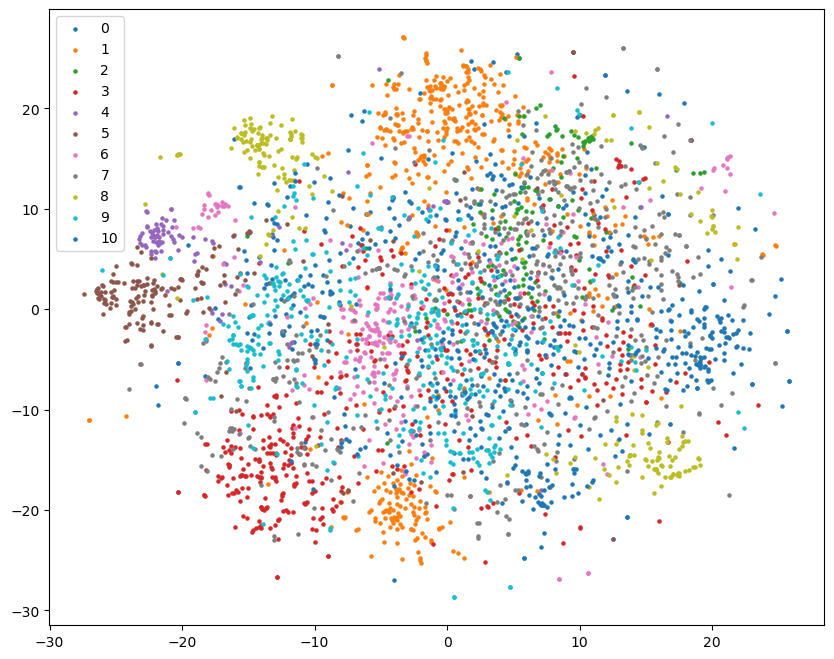

In [14]:
# Load the vaildation set defined by TA
valid_set = FoodDataset("./valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

# Extract the representations for the specific layer of model
index = ... # You should find out the index of layer which is defined as "top" or 'mid' layer of your model.
features = []
labels = []
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model.cnn[:19](imgs.to(device))
        logits = logits.view(logits.size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)
    
features = np.array(features)
colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.legend()
plt.savefig('last.png',dpi = 600)
plt.show()

In [15]:
# Load the vaildation set defined by TA
valid_set = FoodDataset("./valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

# Extract the representations for the specific layer of model
index = ... # You should find out the index of layer which is defined as "top" or 'mid' layer of your model.
features = []
labels = []
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model.cnn[:7](imgs.to(device))
        logits = logits.view(logits.size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)
    
features = np.array(features)
colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.legend()
plt.savefig('mid2.png',dpi = 600)
plt.show()

100%|██████████| 57/57 [00:41<00:00,  1.36it/s]


MemoryError: Unable to allocate 41.3 GiB for an array with shape (3643, 3041536) and data type float32